In [ ]:
import torch
# from vit_model import VisionTransformer  # Removed - using BoxMOT built-in ReID instead

# --- Configuration ---
# NOTE: Custom ReID components have been removed. This notebook is preserved for reference.
# The main tracking pipeline now uses BoxMOT's built-in ReID (OSNet/LightMBN).

# PRETRAINED_MODEL_PATH = '../weights/transformer_120.pth'  # No longer used

print("📝 Custom ReID components have been removed from the codebase.")
print("🔄 The tracking pipeline now uses BoxMOT's built-in ReID model.")
print("📍 This notebook is preserved for reference and experimentation.")

--- Attempting to load pretrained weights ---
Loading from: ../weights/transformer_120.pth

[SUCCESS] Pretrained weights loaded successfully!

--- Debugging Mismatched Keys ---

Keys in the PRETRAINED FILE:
base.cls_token
base.pos_embed
base.patch_embed.conv.0.weight
base.patch_embed.conv.1.IN.weight
base.patch_embed.conv.1.IN.bias
base.patch_embed.conv.1.BN.weight
base.patch_embed.conv.1.BN.bias
base.patch_embed.conv.1.BN.running_mean
base.patch_embed.conv.1.BN.running_var
base.patch_embed.conv.1.BN.num_batches_tracked
base.patch_embed.conv.3.weight
base.patch_embed.conv.4.IN.weight
base.patch_embed.conv.4.IN.bias
base.patch_embed.conv.4.BN.weight
base.patch_embed.conv.4.BN.bias
base.patch_embed.conv.4.BN.running_mean
base.patch_embed.conv.4.BN.running_var
base.patch_embed.conv.4.BN.num_batches_tracked
base.patch_embed.conv.6.weight
base.patch_embed.conv.7.weight
base.patch_embed.conv.7.bias
base.patch_embed.conv.7.running_mean
base.patch_embed.conv.7.running_var
base.patch_embed.conv

In [10]:
import cv2 as cv
from ultralytics import YOLO
video_file = '../v_0/input/3c.mp4'

# Take frame number 100 from the video
cap = cv.VideoCapture(video_file)
frame_number = 500
cap.set(cv.CAP_PROP_POS_FRAMES, frame_number)
ret, frame = cap.read()
cap.release()
if not ret:
    print(f"[ERROR] Could not read frame {frame_number} from video {video_file}.")
else:
    print(f"[SUCCESS] Successfully read frame {frame_number} from video {video_file}.")

    # Using Yolo detect the person and save the crops
    model = YOLO('../weights/yolo11m.pt')  # Load the YOLO model
    results = model(frame)  # Perform inference on the frame

    # Extract the bounding boxes for persons
    person_boxes = []
    for result in results:
        for box in result.boxes:
            if box.cls == 0:  # Class 0 is typically 'person' in YOLO
                person_boxes.append(box.xyxy.cpu().numpy())
    if not person_boxes:
        print("[WARNING] No persons detected in the frame.")
    else:
        print(f"[SUCCESS] Detected {len(person_boxes)} persons in the frame.")

    # Crop and save the detected persons
    for i, box in enumerate(person_boxes):
        print(f"[INFO] Cropping person {i} with bounding box: {box}")
        x1, y1, x2, y2 = map(int, box.flatten())
        person_crop = frame[y1:y2, x1:x2]
        cv.imwrite(f'person_crop_{i}.jpg', person_crop)
        print(f"[SUCCESS] Saved cropped person {i} to 'person_crop_{i}.jpg'.")

[SUCCESS] Successfully read frame 500 from video ../v_0/input/3c.mp4.



[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


0: 384x640 6 persons, 1 backpack, 175.0ms
Speed: 1.7ms preprocess, 175.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
[SUCCESS] Detected 6 persons in the frame.
[INFO] Cropping person 0 with bounding box: [[     691.81      410.97      830.15      871.98]]
[SUCCESS] Saved cropped person 0 to 'person_crop_0.jpg'.
[INFO] Cropping person 1 with bounding box: [[     889.03      573.57      1068.4      1076.3]]
[SUCCESS] Saved cropped person 1 to 'person_crop_1.jpg'.
[INFO] Cropping person 2 with bounding box: [[     723.33      827.99       973.9      1077.9]]
[SUCCESS] Saved cropped person 2 to 'person_crop_2.jpg'.
[INFO] Cropping person 3 with bounding box: [[      799.3      181.57      868.07      389.23]]
[SUCCESS] Saved cropped person 3 to 'person_crop_3.jpg'.
[INFO] Cropping person 4 with bounding box: [[     534.01      1008.4      643.56      1078.5]]
[SUCCESS] Saved cropped person 4 to 'person_crop_4.jpg'.
[INFO] Cropping person 5 with bounding box: [[     7

Matplotlib is building the font cache; this may take a moment.


100%|██████████| 43.3M/43.3M [00:11<00:00, 4.06MB/s]



0: 640x224 1 person, 153.2ms
Speed: 3.1ms preprocess, 153.2ms inference, 8.5ms postprocess per image at shape (1, 3, 640, 224)


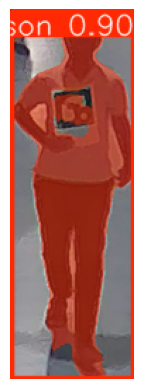

In [1]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2 as cv

# Load the YOLO model
model = YOLO('../weights/yolo11m-seg.pt')

# Load the image
image_path = './person_crop_0.jpg'
image = cv.imread(image_path)

# Perform inference on the image
results = model(image)

# Visualize the results
for result in results:
    # Draw bounding boxes and masks on the image
    annotated_image = result.plot()
    
# Display the annotated image
plt.imshow(annotated_image)
plt.axis('off')  # Hide axes
plt.show()

✅ Loaded GaitParsing weights from ../weights/human_parsing.pth


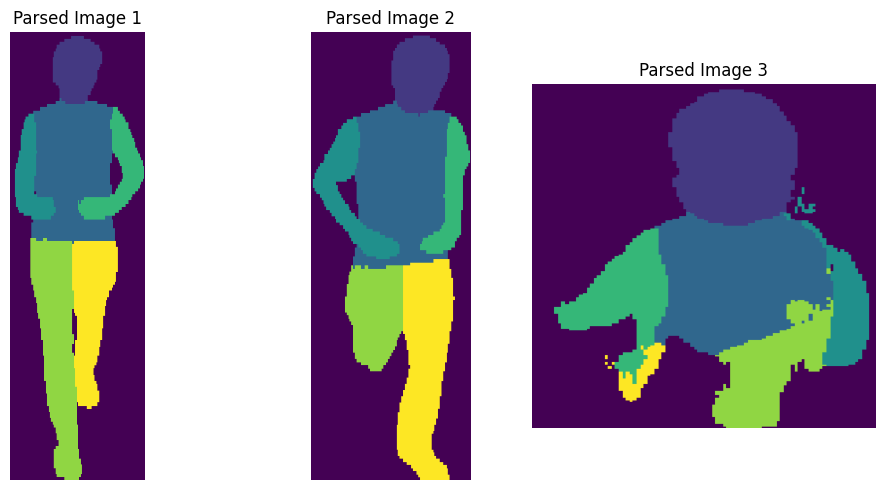

In [14]:
# Human Parsing
import cv2 as cv
import matplotlib.pyplot as plt
from torchvision import transforms
from parsing import HumanParsingModel
# Initialize the human parsing model
parsing_model = HumanParsingModel(model_path='../weights/human_parsing.pth')
image1 = cv.imread('./person_crop_0.jpg')
image2 = cv.imread('./person_crop_1.jpg')
image3 = cv.imread('./person_crop_2.jpg')
images = [image1, image2, image3]
# Perform human parsing on the cropped person image
parsed_image1, parsed_image2, parsed_image3 = parsing_model.extract_parsing(images)
# Display the parsed image
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(parsed_image1)
plt.axis('off')
plt.title('Parsed Image 1')

plt.subplot(1, 3, 2)
plt.imshow(parsed_image2)
plt.axis('off')
plt.title('Parsed Image 2')

plt.subplot(1, 3, 3)
plt.imshow(parsed_image3)  # Assuming you want to show the same parsed image for comparison
plt.axis('off')
plt.title('Parsed Image 3')

plt.tight_layout()

plt.show()

In [2]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import logging
from u2net import U2NET # Make sure the u2net.py file is in your project directory

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def create_silhouette_extractor(weights_path='../weights/u2net_human_seg.pth'):
    """
    Create a silhouette extractor using the U²-Net model.
    """
    try:
        # Determine the processing device
        device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
        logger.info(f"Using device: {device}")

        # Load the U²-Net model
        model = U2NET()
        logger.info("U²-Net model loaded successfully.")

        # Move the model to the selected device *before* loading the weights
        model.to(device)

        # Load the pretrained weights, mapping them to the same device
        model.load_state_dict(torch.load(weights_path, map_location=device))
        logger.info(f"Pretrained weights loaded from {weights_path}.")

        # Set the model to evaluation mode
        model.eval()
        logger.info("Model set to evaluation mode.")

        return model, device
    except Exception as e:
        logger.error(f"Failed to create silhouette extractor: {e}")
        raise e

def extract_silhouette(model, device, input_image):
    """
    Extract a silhouette from the input image using the U²-Net model.
    """
    try:
        # --- Preprocessing (same as before) ---
        original_height, original_width = input_image.shape[:2]
        resized_image = cv2.resize(input_image, (320, 320))
        input_tensor = torch.from_numpy(resized_image.transpose((2, 0, 1))).float().unsqueeze(0) / 255.0
        input_tensor = input_tensor.to(device)

        # --- Model Inference (same as before) ---
        with torch.no_grad():
            pred = model(input_tensor)[0]

        # --- Mask Conversion and Normalization (same as before) ---
        silhouette_raw = pred.squeeze().cpu().numpy()
        # silhouette_norm = (silhouette_raw - np.min(silhouette_raw)) / (np.max(silhouette_raw) - np.min(silhouette_raw))
        # grayscale_mask = (silhouette_norm * 255).astype(np.uint8)
        
        # --- NEW: Apply a binary threshold ---
        # Any pixel value above 128 will become 255 (white), and all others will become 0 (black).
        # _, binary_mask = cv2.threshold(grayscale_mask, 128, 255, cv2.THRESH_BINARY)

        # --- Resize back to original image size ---
        final_silhouette = cv2.resize(silhouette_raw, (original_width, original_height))

        return final_silhouette # Return the new binary mask
    except Exception as e:
        logger.error(f"Error during silhouette extraction: {e}")
        raise e

# --- IMPORTANT: Update your main execution block ---
if __name__ == "__main__":
    try:
        extractor, device = create_silhouette_extractor(weights_path='../weights/u2net_human_seg.pth')

        input_image = cv2.imread('./person_crop_2.jpg')
        if input_image is None:
            raise FileNotFoundError("Test image not found. Please check the path './person_crop_2.jpg'.")

        # Extract the silhouette
        silhouette_mask = extract_silhouette(extractor, device, input_image)

        # Save the output mask to a file to verify it
        output_filename = "test_silhouette_output.png"
        cv2.imwrite(output_filename, silhouette_mask)
        print(f"Silhouette mask saved to {output_filename}")

        # Display the input and output images using OpenCV
        # cv2.imshow("Input Image", input_image)
        # cv2.imshow("Silhouette Mask", silhouette_mask)
        # print("Press any key to close the windows.")
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()

    except Exception as e:
        print(f"An error occurred: {e}")

INFO:__main__:Using device: mps
INFO:__main__:U²-Net model loaded successfully.
INFO:__main__:Pretrained weights loaded from ../weights/u2net_human_seg.pth.
INFO:__main__:Model set to evaluation mode.


Silhouette mask saved to test_silhouette_output.png


In [10]:
# I have the u2net architecture match with the weights file if any missing keys, it will print them out.

pretrained_model = torch.load('../weights/u2net_human_seg.pth', map_location='cpu')
print("Pretrained model loaded successfully.")
print("Keys in the pretrained model:")
for key in pretrained_model.keys():
    print(key)

# u2net architecture match with the weights file if any missing keys, it will print them out.
u2net_architecture = U2NET()
print("Keys in the U2NET architecture:")
for key in u2net_architecture.state_dict().keys():
    print(key)

# If there are any mismatched keys, they will be printed out.
missing_keys = []
for key in pretrained_model.keys():
    if key not in u2net_architecture.state_dict():
        missing_keys.append(key)
if missing_keys:
    print("\nMissing keys in the U2NET architecture:")
    for key in missing_keys:
        print(key)
else:
    print("\nAll keys match between the pretrained model and the U2NET architecture.")

Pretrained model loaded successfully.
Keys in the pretrained model:
stage1.rebnconvin.conv_s1.weight
stage1.rebnconvin.conv_s1.bias
stage1.rebnconvin.bn_s1.weight
stage1.rebnconvin.bn_s1.bias
stage1.rebnconvin.bn_s1.running_mean
stage1.rebnconvin.bn_s1.running_var
stage1.rebnconvin.bn_s1.num_batches_tracked
stage1.rebnconv1.conv_s1.weight
stage1.rebnconv1.conv_s1.bias
stage1.rebnconv1.bn_s1.weight
stage1.rebnconv1.bn_s1.bias
stage1.rebnconv1.bn_s1.running_mean
stage1.rebnconv1.bn_s1.running_var
stage1.rebnconv1.bn_s1.num_batches_tracked
stage1.rebnconv2.conv_s1.weight
stage1.rebnconv2.conv_s1.bias
stage1.rebnconv2.bn_s1.weight
stage1.rebnconv2.bn_s1.bias
stage1.rebnconv2.bn_s1.running_mean
stage1.rebnconv2.bn_s1.running_var
stage1.rebnconv2.bn_s1.num_batches_tracked
stage1.rebnconv3.conv_s1.weight
stage1.rebnconv3.conv_s1.bias
stage1.rebnconv3.bn_s1.weight
stage1.rebnconv3.bn_s1.bias
stage1.rebnconv3.bn_s1.running_mean
stage1.rebnconv3.bn_s1.running_var
stage1.rebnconv3.bn_s1.num_batch

In [ ]:
# All keys matched check for the input size that the model expects
input_size = (320, 320)  # U2NET expects input size of 320x320
print(f"\nInput size expected by the model: {input_size}")

# Shilhouette

In [3]:
import cv2
import numpy as np
img = cv2.imread('person_crop_2.jpg', cv2.IMREAD_GRAYSCALE)
_, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

# Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on a blank image (silhouette)
silhouette = np.zeros_like(img)
cv2.drawContours(silhouette, contours, -1, (255), thickness=cv2.FILLED)

cv2.imshow("Silhouette", silhouette)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [13]:
import torch
from torch.autograd import Variable
import numpy as np
import cv2
from torchvision import transforms
from PIL import Image
import os
from models.u2net import U2NET 
from matplotlib import pyplot as plt
# Load the pre-trained U-2-Net model
model = U2NET()
model.load_state_dict(torch.load('../weights/human_parsing.pth', map_location=torch.device('cpu')))
model.eval()


# Load image
img_path = 'person_crop_3.jpg'  # Path to your person crop image
img = Image.open(img_path).convert('RGB')

# Preprocess image
preprocess = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img_tensor = preprocess(img).unsqueeze(0)
img_tensor = Variable(img_tensor)

# Run the model to get the segmentation mask
with torch.no_grad():
    output = model(img_tensor)[0][0]

# Post-process output
output = output.data.cpu().numpy()
output = (output - np.min(output)) / (np.max(output) - np.min(output))  # Normalize
output = (output * 255).astype(np.uint8)

# Convert to binary mask (silhouette)
# Convert to binary mask (silhouette)
_, binary_mask = cv2.threshold(output, 127, 255, cv2.THRESH_BINARY)

# Squeeze the extra dimension and display the result
binary_mask = np.squeeze(binary_mask)  # Remove the batch dimension
plt.imshow(binary_mask, cmap='gray')
plt.axis('off')
plt.show()


RuntimeError: Error(s) in loading state_dict for U2NET:
	size mismatch for side1.weight: copying a param with shape torch.Size([7, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([1, 64, 3, 3]).
	size mismatch for side1.bias: copying a param with shape torch.Size([7]) from checkpoint, the shape in current model is torch.Size([1]).
	size mismatch for side2.weight: copying a param with shape torch.Size([7, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([1, 64, 3, 3]).
	size mismatch for side2.bias: copying a param with shape torch.Size([7]) from checkpoint, the shape in current model is torch.Size([1]).
	size mismatch for side3.weight: copying a param with shape torch.Size([7, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([1, 128, 3, 3]).
	size mismatch for side3.bias: copying a param with shape torch.Size([7]) from checkpoint, the shape in current model is torch.Size([1]).
	size mismatch for side4.weight: copying a param with shape torch.Size([7, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([1, 256, 3, 3]).
	size mismatch for side4.bias: copying a param with shape torch.Size([7]) from checkpoint, the shape in current model is torch.Size([1]).
	size mismatch for side5.weight: copying a param with shape torch.Size([7, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([1, 512, 3, 3]).
	size mismatch for side5.bias: copying a param with shape torch.Size([7]) from checkpoint, the shape in current model is torch.Size([1]).
	size mismatch for side6.weight: copying a param with shape torch.Size([7, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([1, 512, 3, 3]).
	size mismatch for side6.bias: copying a param with shape torch.Size([7]) from checkpoint, the shape in current model is torch.Size([1]).
	size mismatch for outconv.weight: copying a param with shape torch.Size([7, 42, 1, 1]) from checkpoint, the shape in current model is torch.Size([1, 6, 1, 1]).
	size mismatch for outconv.bias: copying a param with shape torch.Size([7]) from checkpoint, the shape in current model is torch.Size([1]).